In [22]:
import os
import pickle
import numpy as np

In [23]:
# load in files
x_vals, y_vals, freqs = None, None, None
earth_list = []
xx = None
yy = np.array([])

file_list = os.listdir('../forward_data/batch_simulation0')

for file in file_list:
    with open('../forward_data/batch_simulation0/' + file, 'rb') as f:
        data, earth = pickle.load(f)
    if x_vals is None:
        x_vals = [data[i]['x'] for i in range(len(data))]
        y_vals = [data[i]['y'] for i in range(len(data))]
        freqs = data[0]['frequencies']
    reals = np.stack([data[i]['hz_real'] for i in range(len(data))])
    imags = np.stack([data[i]['hz_imag'] for i in range(len(data))])
    # combine the real and imaginary parts
    measurements = np.hstack([reals, imags])
    # determine if there are uxos
    is_uxo = np.array([earth.layers_at_pt((x_vals[i], y_vals[i]))[0].shape[0] // 2 for i in range(len(x_vals))])
    earth_list.append(earth)
    if xx is None:
        xx = measurements
    else:
        xx = np.concatenate([xx, measurements])
    yy = np.concatenate([yy, is_uxo])

In [24]:
xx.shape, yy.shape

((10000, 10), (10000,))

In [25]:
# split the data into training and testing
from sklearn.model_selection import train_test_split

test_frac = 0.2
x_train, x_test, y_train, y_test = train_test_split(xx, yy, test_size=test_frac, shuffle=False)

In [26]:
# perform logistic regression

class LogisticRegressionBinary:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.weights = None
        self.bias = None
        self.mean = None
        self.std = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        # normalize the data
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        X = (X - self.mean) / self.std

        # Initialize parameters
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient Descent
        for _ in range(self.iterations):
            # Compute model predictions
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)

            # Compute gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        # Normalize the data
        X = (X - self.mean) / self.std
        # Predict probabilities
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        # Convert probabilities to binary labels
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_predicted_cls)

# # Example usage:
# if __name__ == "__main__":
#     # Example data
#     X = np.array([[1, 2], [2, 3], [3, 4], [4, 5], [5, 6]])
#     y = np.array([0, 0, 1, 1, 1])

#     # Train logistic regression model
#     model = LogisticRegressionBinary(learning_rate=0.01, iterations=1000)
#     model.fit(X, y)

#     # Make predictions
#     predictions = model.predict(X)
#     print("Predictions:", predictions)


In [27]:
regression_model = LogisticRegressionBinary(learning_rate=0.01, iterations=1000)
regression_model.fit(x_train, y_train)
predictions = regression_model.predict(x_test)

In [65]:
y_test[0:100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [28]:
# evaluate the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
print("Accuracy:", accuracy_score(y_test, predictions))
print("Recall:", recall_score(y_test, predictions))

Accuracy: 1.0
Recall: 1.0


In [83]:
idx = 84
earth_list[80].layers_at_pt((x_vals[idx], y_vals[idx]))

(array([1.35689967, 1.40140106]),
 array([9.79906984e-02, 2.65570089e+05, 9.79906984e-02]))

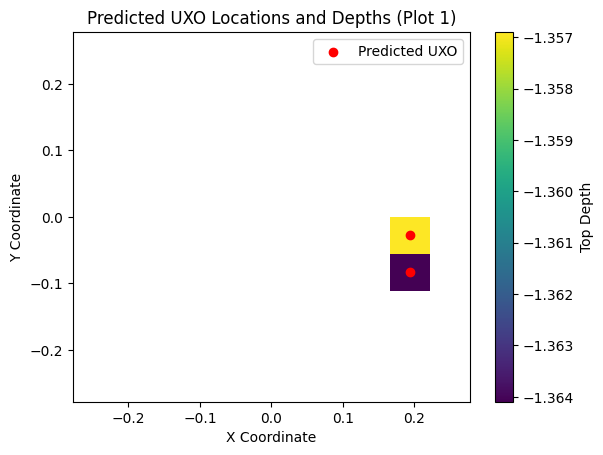

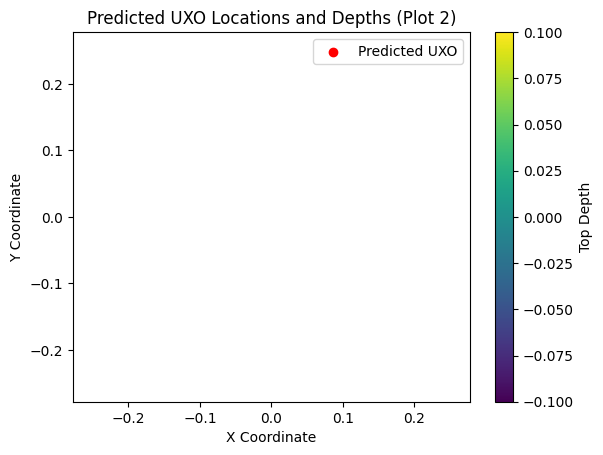

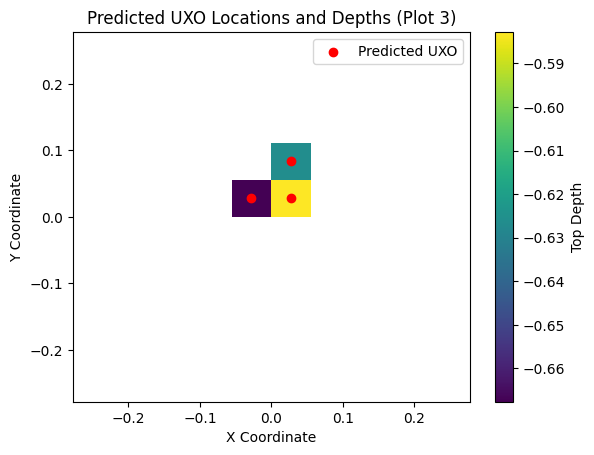

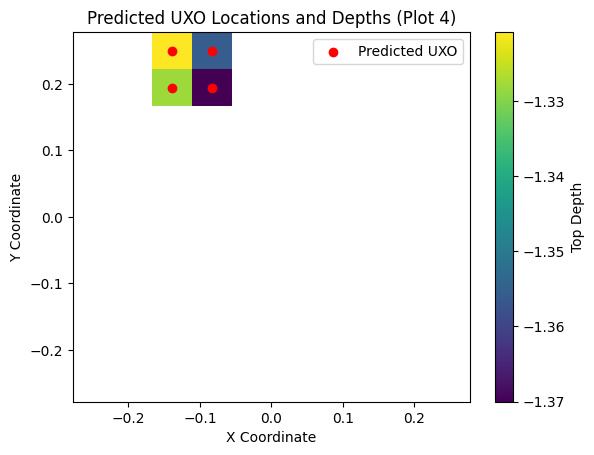

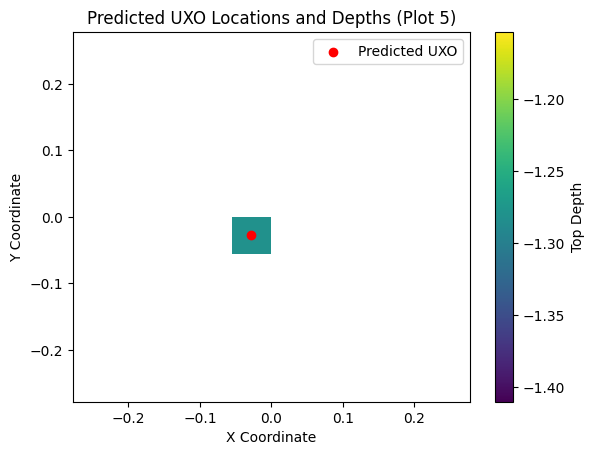

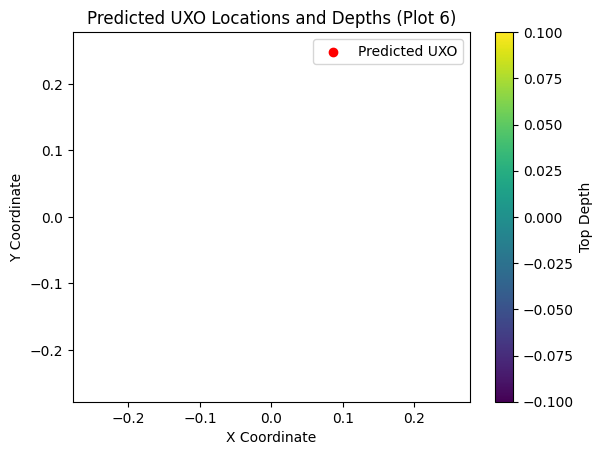

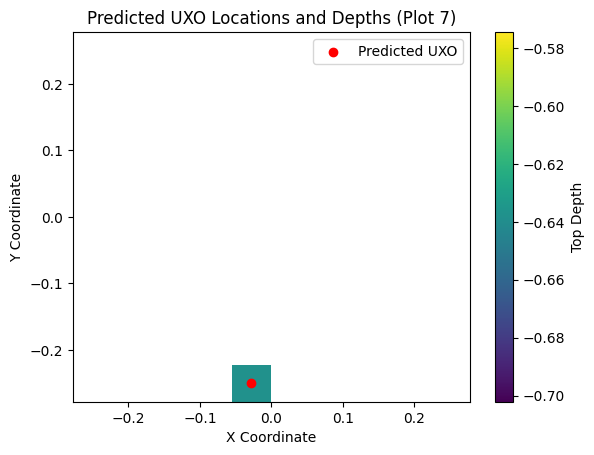

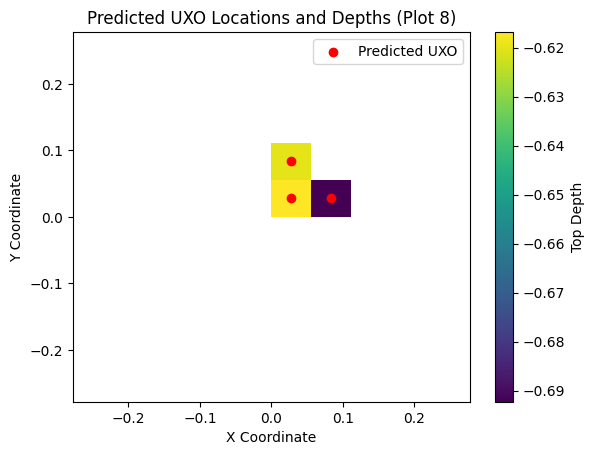

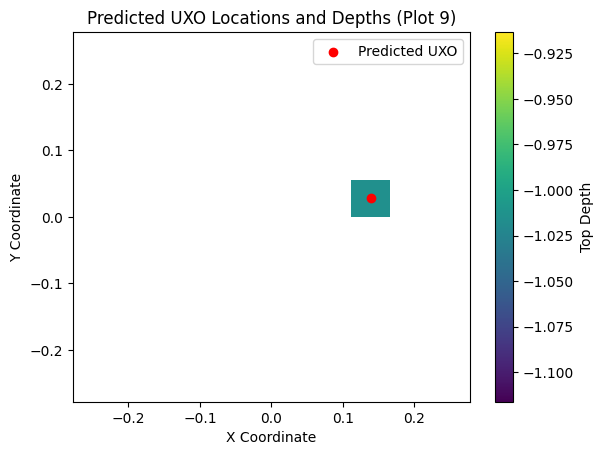

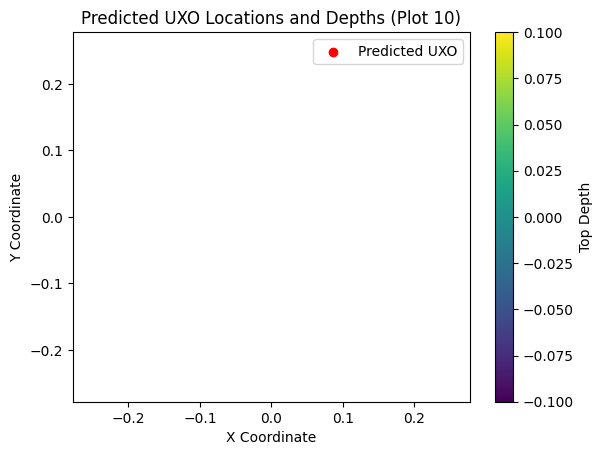

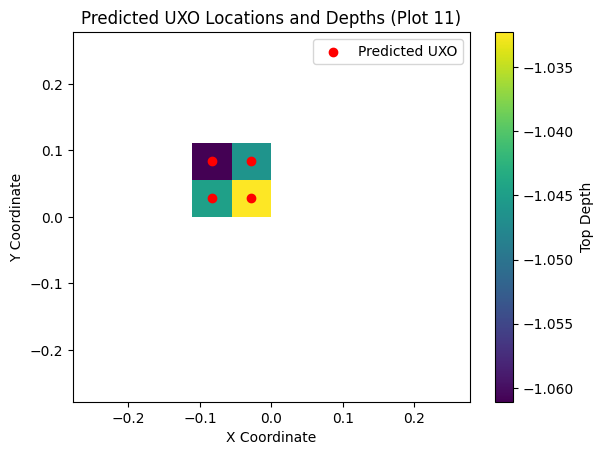

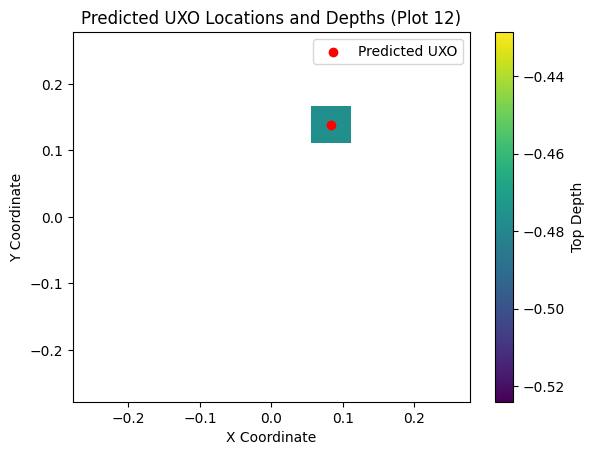

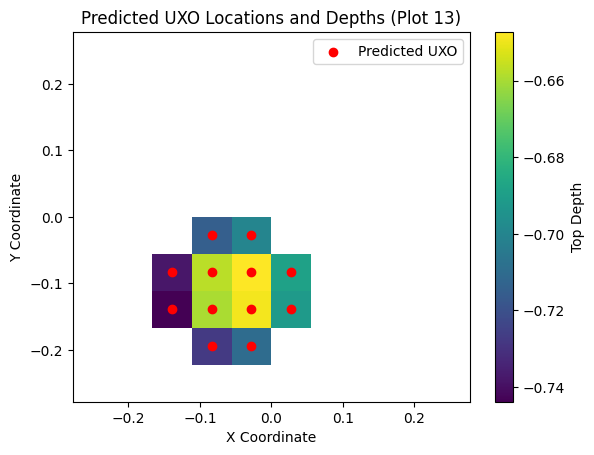

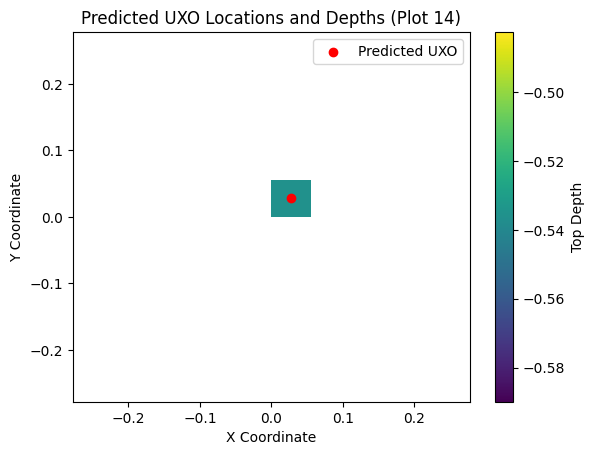

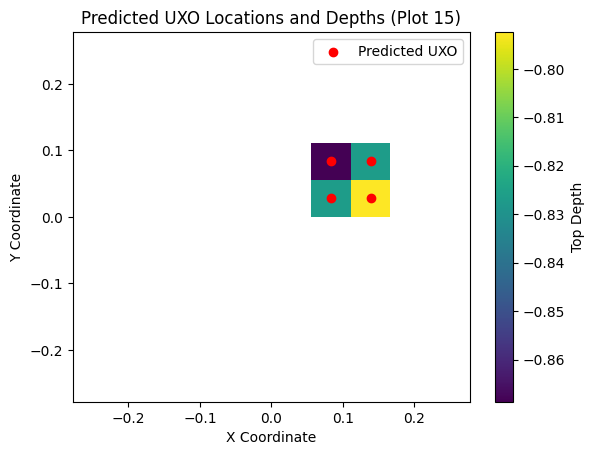

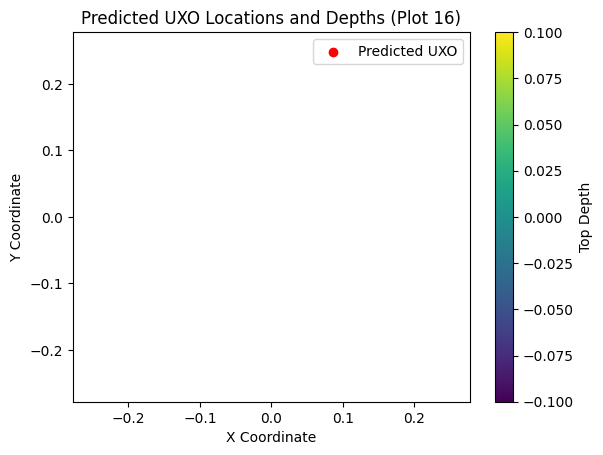

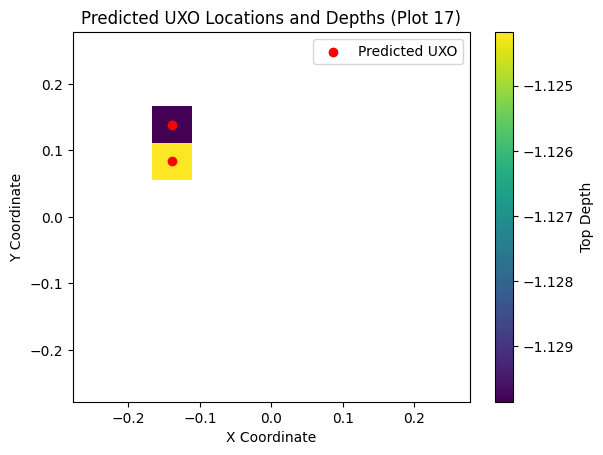

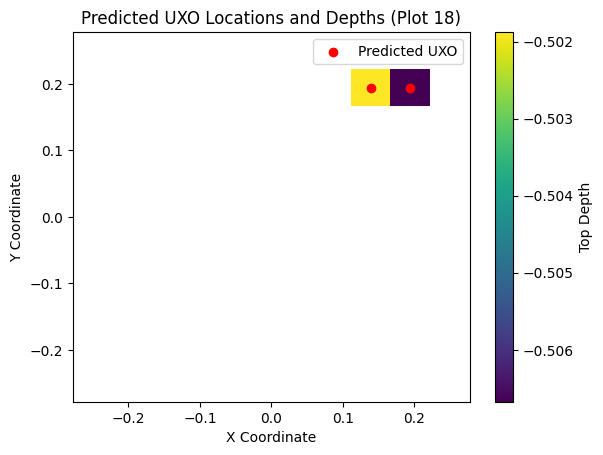

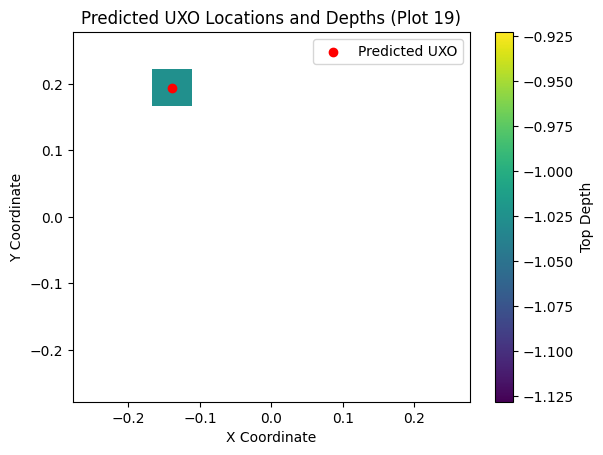

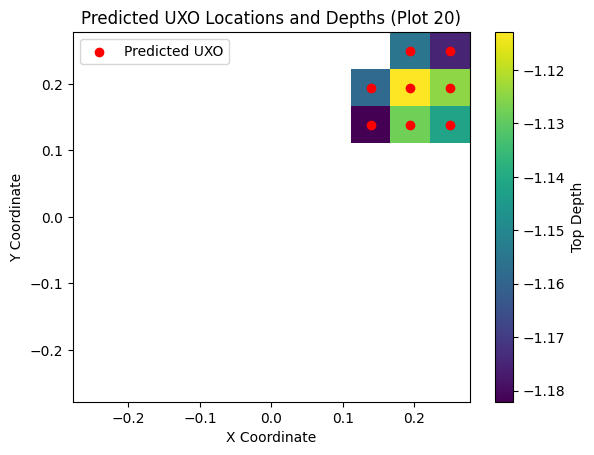

In [93]:
# plot the results
import matplotlib.pyplot as plt
n_plots = len(y_test) // len(y_vals)
n_sims = yy.shape[0] // len(y_vals)
x_raster = np.linspace(min(x_vals), max(x_vals), int(np.sqrt(len(x_vals))))
y_raster = np.linspace(min(y_vals), max(y_vals), int(np.sqrt(len(y_vals))))

for i in range(n_plots):
    earth = earth_list[int(n_sims * (1-test_frac)) + i]
    top_depths = np.zeros(len(y_vals))
    for j in range(len(y_vals)):
        try:
            top_depths[j] = -earth.layers_at_pt((x_vals[j], y_vals[j]))[0][0]
        except:
            top_depths[j] = np.nan
    current_predictions = predictions[i*len(y_vals):(i+1)*len(y_vals)]
    x_uxo = [x_vals[j] for j in range(len(x_vals)) if current_predictions[j] == 1]
    y_uxo = [y_vals[j] for j in range(len(y_vals)) if current_predictions[j] == 1]
    # Create the plot
    plt.figure()
    grid_size = int(np.sqrt(len(x_vals)))
    depth_grid = top_depths.reshape((grid_size, grid_size), order='F')
    
    # Plot the depth heatmap
    depth_plot = plt.pcolormesh(x_raster, y_raster, depth_grid, cmap='viridis', shading='auto')
    plt.colorbar(depth_plot, label='Top Depth')  # Add a colorbar with a label
    
    # Overlay UXO predictions as red scatter points
    plt.scatter(x_uxo, y_uxo, color='red', label='Predicted UXO')
    
    # Add plot titles and labels
    plt.title(f"Predicted UXO Locations and Depths (Plot {i+1})")
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    
    # Show the plot
    plt.show()